## Options structural break detection, 3yrs

In [1]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime
from pprint import pprint

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from time_series_utils import timeseries_evaluation_metrics_func, mean_absolute_percentage_error,\
                          find_best_ETS_model, get_nth_train_split

Importing plotly failed. Interactive plots will not work.


## Cboe Options Historical Volume and Put/Call Ratios

### Index Options

In [6]:
from datetime import datetime, timedelta
import pickle

In [7]:
pickle_dir = "../results_pickle_format"

In [8]:
with open(f'{pickle_dir}/IDX_options.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [9]:
df2 = df2[:'2013-01-01']


<AxesSubplot:xlabel='Date'>

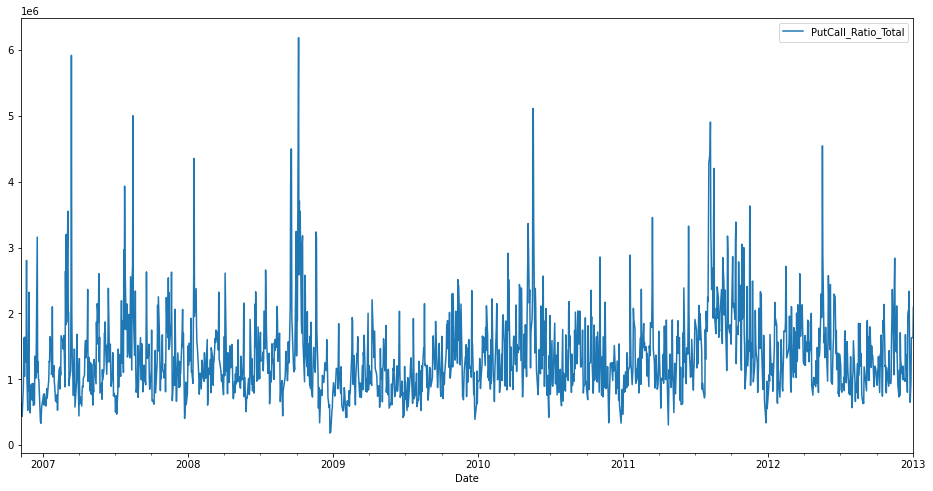

In [10]:
df2.plot(figsize=(16,8))

## What we are going to do. 

start_time + M months = interval_1 <- hyperparameter tuning 

then fit and predict the next 1 week. 

new start_time is interval_1 end + 1 weeks => 
start_time_1 + M months =  interval_2 <- hyperparameter tuning 

then fix and predict the next 1 week.

Repeat for 156 times. 

### Fine tune hyperparameter and forecast on moving window of 1 week increment up to 156 weeks (3 years) 

In [8]:
# Value Columns to be used in all models tuning
value_col = 'PutCall_Ratio_Total'

In [ ]:
TRAIN_WEEKS = 12 

## Holt Winters Exponential Smoothing (ETS)

Find best hyperparameters using train2 and validation data. 
train_week_length = 12

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [10]:
%%capture

ETS_MAPES = []
steps = 156  # number of windowing steps (unit week)

pred_df = None 

for i in range(steps):
    train_data, val_data, test_data = get_nth_train_split(df2, i, train_week_len=TRAIN_WEEKS)
    _, best_MAE, best_ETS_MAE_params = find_best_ETS_model(
        train_data, val_data, value_col=value_col, seasonal_periods=[7,30])
    trend, seasonal, seasonal_period = best_ETS_MAE_params 
    ETS_model_updated = ExponentialSmoothing(train_data[value_col], trend=trend, seasonal=seasonal,\
                                         seasonal_periods=seasonal_period).fit()
    test_pred_ETS = ETS_model_updated.forecast(len(test_data))
    test_pred_ETS = pd.DataFrame(test_pred_ETS, columns=['prediction'])
    if i == 0:
        pred_df = test_pred_ETS
    else:
        pred_df = pd.concat([pred_df, test_pred_ETS])
    MAPE = mean_absolute_percentage_error(test_data[value_col], test_pred_ETS)
    ETS_MAPES.append((MAPE,(test_data.index[0], test_data.index[-1])))

    print("prediction ETS")
    print(test_pred_ETS)
    
    print("*********************************************")
    print()
    print(f"finishing step: {i}")
    print()
    print("**********************************************")
     
print(f"ETS MAPES:\n {ETS_MAPES}")

In [11]:
pred_df.index.name = 'Date'
pred_df.head(3)

prediction
Date                    
2007-01-30  1.137958e+06
2007-01-31  1.138309e+06
2007-02-01  1.130324e+06

In [12]:
import pickle

with open(f'{pickle_dir}/ETS_interval_12w_IDX_2007-2009.pkl', 'wb') as f:
    pickle.dump(ETS_MAPES, f)

In [13]:

with open(f'{pickle_dir}/ETS_interval_12w_IDX_pred_2007-2009.pkl', 'wb') as f:
    pickle.dump(pred_df, f)

## ETS mapes

In [17]:
ETS_MAPES

[(31.428828700252165,
  (Timestamp('2007-02-06 00:00:00', freq='D'),
   Timestamp('2007-02-12 00:00:00', freq='D'))),
 (45.98751640191966,
  (Timestamp('2007-02-13 00:00:00', freq='D'),
   Timestamp('2007-02-19 00:00:00', freq='D'))),
 (29.250242694806843,
  (Timestamp('2007-02-20 00:00:00', freq='D'),
   Timestamp('2007-02-26 00:00:00', freq='D'))),
 (44.313502751406965,
  (Timestamp('2007-02-27 00:00:00', freq='D'),
   Timestamp('2007-03-05 00:00:00', freq='D'))),
 (42.924779391169025,
  (Timestamp('2007-03-06 00:00:00', freq='D'),
   Timestamp('2007-03-12 00:00:00', freq='D'))),
 (127.4289622926393,
  (Timestamp('2007-03-13 00:00:00', freq='D'),
   Timestamp('2007-03-19 00:00:00', freq='D'))),
 (33.0265425823709,
  (Timestamp('2007-03-20 00:00:00', freq='D'),
   Timestamp('2007-03-26 00:00:00', freq='D'))),
 (44.51416836568002,
  (Timestamp('2007-03-27 00:00:00', freq='D'),
   Timestamp('2007-04-02 00:00:00', freq='D'))),
 (47.087417171057886,
  (Timestamp('2007-04-03 00:00:00', fre